# Train the Linear Latent Variable Model


In [1]:
import pathlib
import corner
import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import h5py
from tqdm import tqdm
from sklearn.neighbors import KDTree
from pyia import GaiaData
from scipy.stats import binned_statistic

from jax.config import config
config.update("jax_enable_x64", True)
import jaxopt
import optax

import schlummernd as sch
from schlummernd.lvm import LinearLVM

In [2]:
conf = sch.Config.parse_yaml('../config.yml')

## Load APOGEE x Gaia data

see `Assemble-data.ipynb` for more information.

In [3]:
g_all = conf.load_training_data()

In [4]:
hoods = np.load(conf.data_path / 'training_neighborhoods.npy')

In [7]:
k = 5
g = g_all[hoods[k]]

In [8]:
# g = g_all[(np.abs(g_all.b) > 15*u.deg) & (g_all.SFD_EBV < 0.2)]
# len(g)

In [9]:
bprp = (g.phot_bp_mean_mag - g.phot_rp_mean_mag).value
mg = (g.phot_g_mean_mag - g.get_distance(allow_negative=True).distmod).value

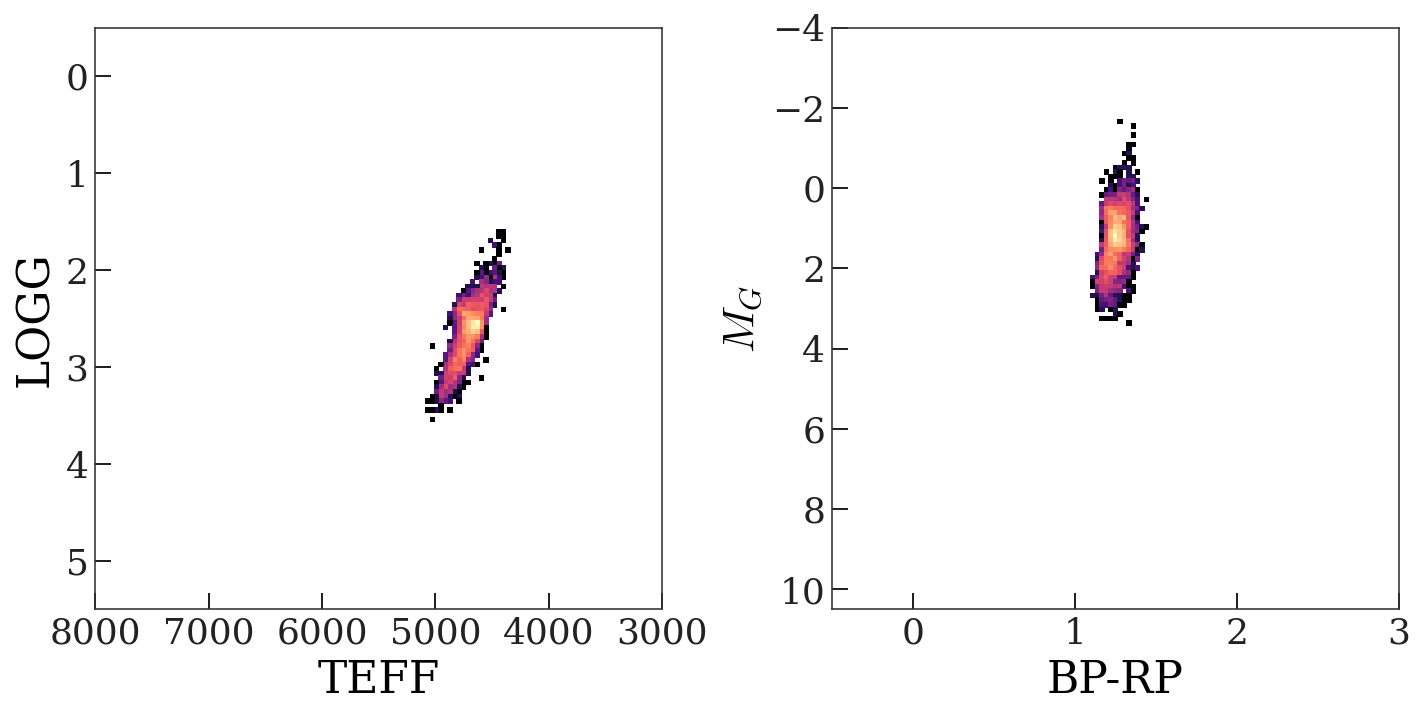

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
H, xb, yb, _ = ax.hist2d(
    g.TEFF,
    g.LOGG,
    bins=(
        np.linspace(3000, 8000, 128),
        np.linspace(-0.5, 5.5, 128)
    ),
    norm=mpl.colors.LogNorm()
)
ax.set_xlim(xb.max(), xb.min())
ax.set_ylim(yb.max(), yb.min())
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')

ax = axes[1]
H, xb, yb, _ = ax.hist2d(
    bprp,
    mg,
    bins=(
        np.linspace(-0.5, 3, 128),
        np.linspace(-4, 10.5, 128)
    ),
    norm=mpl.colors.LogNorm()
)
ax.set_xlim(xb.min(), xb.max())
ax.set_ylim(yb.max(), yb.min())
ax.set_xlabel('BP-RP')
ax.set_ylabel('$M_G$')

fig.tight_layout()

# Construct features and labels

Make list of possible labels (and label weights), aligned with the features.

In [13]:
# other_features = {
#     r"$G_{\rm BP}-G_{\rm RP}$": 0.1 * (g.phot_bp_mean_mag - g.phot_rp_mean_mag).value
# }
f_all = sch.Features.from_gaiadata(g, n_bp=32, n_rp=32) # , **other_features)
# f_all = Features.from_gaiadata(g, n_bp=25, n_rp=25) # , **other_features)

In [15]:
lbl = sch.Labels()

schmag_factor = 10 ** (0.2 * g.phot_g_mean_mag.value) / 100.
lbl.add_label(
    'schmag',
    value=g.parallax.value * schmag_factor,
    err=g.parallax_error.value * schmag_factor,
    label='$G$-band schmag [absmgy$^{-1/2}$]'
)
lbl.add_label(
    'TEFF',
    g.TEFF,
    g.TEFF_ERR,
    label=r"$T_{\rm eff}$ [K]"
)
lbl.add_label(
    'M_H',
    g.M_H,
    g.M_H_ERR,
    label=r"$[{\rm M}/{\rm H}]$"
)
lbl.add_label(
    'logg',
    g.LOGG,
    g.LOGG_ERR,
    label=r"$\log g$"
)

assert np.all(lbl.y_err > 0)

lbl.y.shape

(4096, 4)

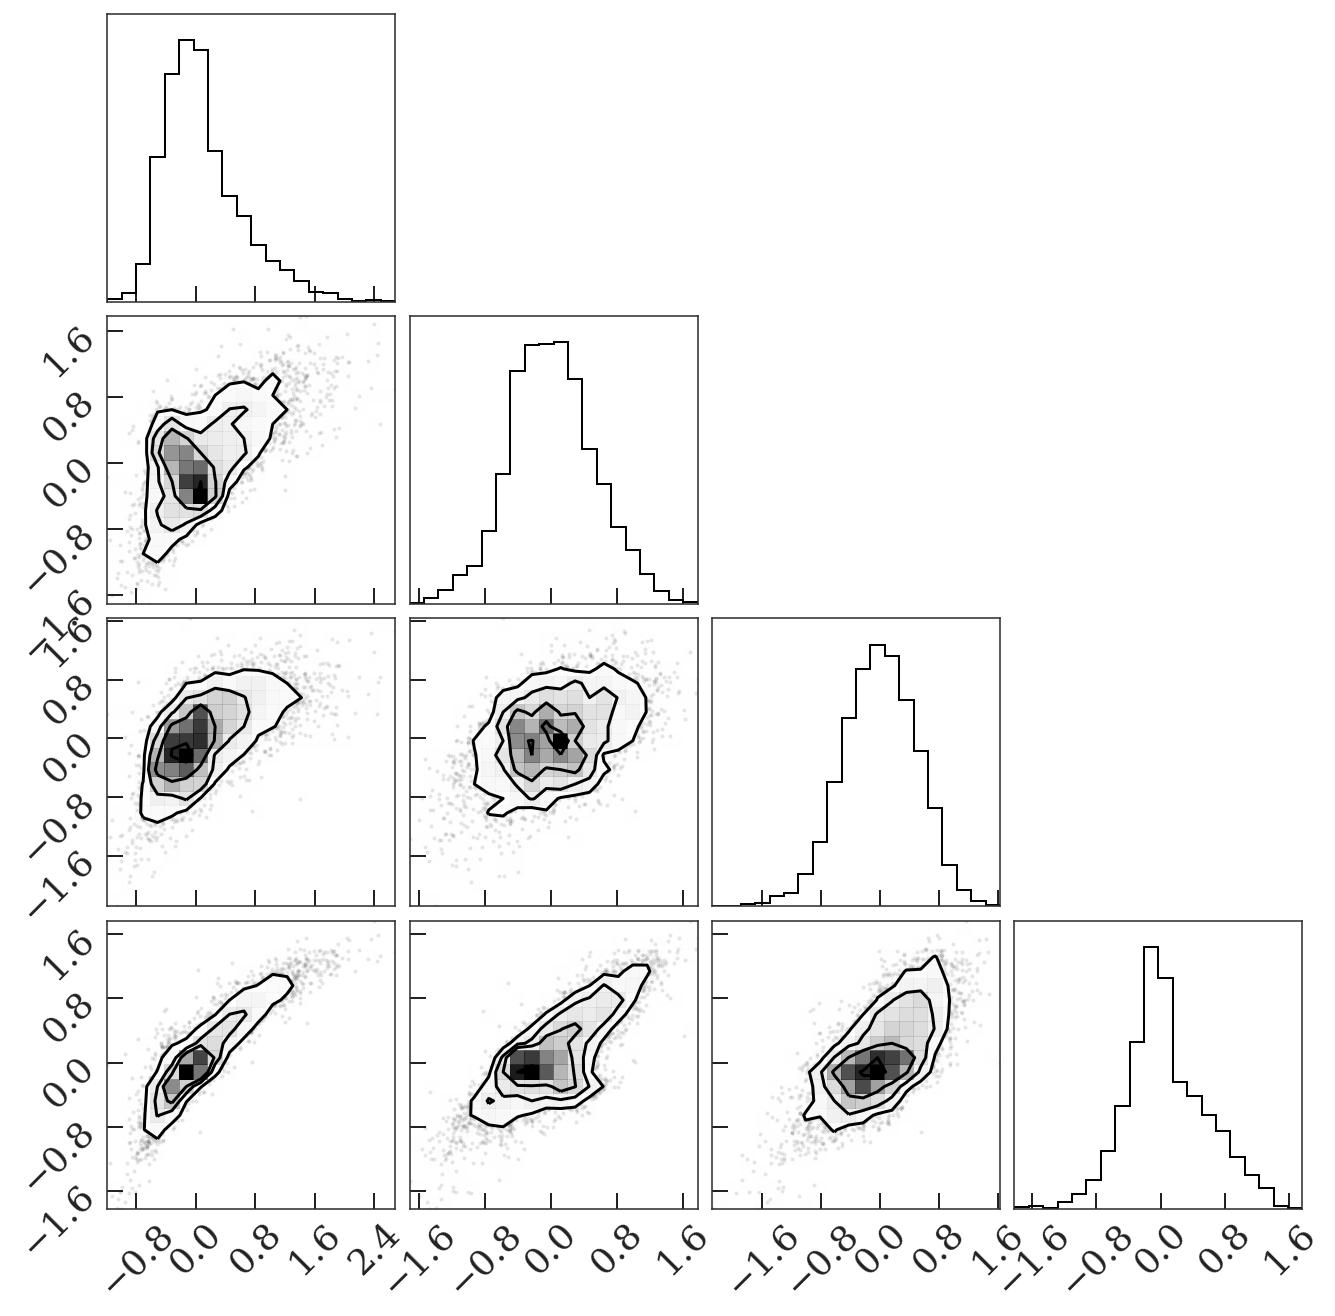

In [18]:
_ = corner.corner(lbl.y)

# Make training and validation samples

cut into eighths

In [19]:
rng = np.random.default_rng(seed=42)

rando = rng.integers(8, size=len(f_all))
train = rando != 0
valid = (
    ~train &
#     (g.LOGG < 2.2) &
    ((lbl.vals['schmag'] / lbl.errs['schmag']) > 8)
)

f_train = f_all[train]
f_valid = f_all[valid]

X_train, X_valid = f_train.X, f_valid.X
X_train_err, X_valid_err = f_train.X_err, f_valid.X_err
y_train, y_valid = lbl.y[train], lbl.y[valid]
y_train_err, y_valid_err = lbl.y_err[train], lbl.y_err[valid]

print(X_train.shape, X_valid.shape)
print(X_train_err.shape, X_valid_err.shape)
print(y_train.shape, y_valid.shape)
print(y_train_err.shape, y_valid_err.shape)

(3603, 64) (489, 64)
(3603, 64) (489, 64)
(3603, 4) (489, 4)
(3603, 4) (489, 4)


In [20]:
# _ = corner.corner(X_train)

In [21]:
# _ = corner.corner(X_valid)

# Find neighbors for validation sample stars

In [22]:
K = 128  # TODO: need to assess this  
n_xp_tree = 8  # MAGIC
# n_xp_tree = 5

X_tree = f_all.slice_bp(n_xp_tree).slice_rp(n_xp_tree).X_tree
X_train_tree = X_tree[train]
X_valid_tree = X_tree[valid]

tree = KDTree(X_train_tree, leaf_size=32) # magic
dists, inds = tree.query(X_valid_tree, k=K)
print(X_valid.shape, dists.shape, inds.shape)

(489, 64) (489, 128) (489, 128)


# Run LLVM model


## Per-source:

In [23]:
valid_n = 35
idx = inds[valid_n]

rng = np.random.default_rng(42)
n_labels = y_train.shape[1]
n_latents = n_labels + 1
B = np.zeros((n_labels, n_latents))
B[:n_labels, :n_labels] = np.eye(n_labels)

llvm = LinearLVM(
    X_train[idx], y_train[idx], 
    X_train_err[idx], y_train_err[idx], 
    B, alpha=1e-1, beta=1e-1, 
    verbose=True, rng=rng
)

no free elements of B
B = [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
B fit elements = [[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
using 1 unconstrained elements of z, out of 5 latents
Lambda = [[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1]]


In [24]:
x0 = llvm.pack_p()
print(x0.shape)

(1028,)


In [25]:
solver = jaxopt.LBFGS(fun=llvm, maxiter=2**15)
res_bfgs = solver.run(x0)
print(res_bfgs.state.iter_num)

32768


In [26]:
opt = optax.adam(1e-4)
solver = jaxopt.OptaxSolver(opt=opt, fun=llvm, maxiter=2**15)
res_adam = solver.run(x0)
print(res_adam.state.iter_num)

32768


In [27]:
print(
    llvm(x0),
    llvm(res_bfgs.params),
    llvm(res_adam.params)
)

6004.622857303732 3913.464047021499 3914.319929554499


In [28]:
# res_state = llvm.unpack_p(res_bfgs.params)
res_state = llvm.unpack_p(res_adam.params)

### Self-test:

In [29]:
y_train_predict0 = llvm.predict_y(
    X_train[idx], 
    X_train_err[idx], 
    llvm.par_state
)

y_train_predict = llvm.predict_y(
    X_train[idx], 
    X_train_err[idx],  
    res_state
)

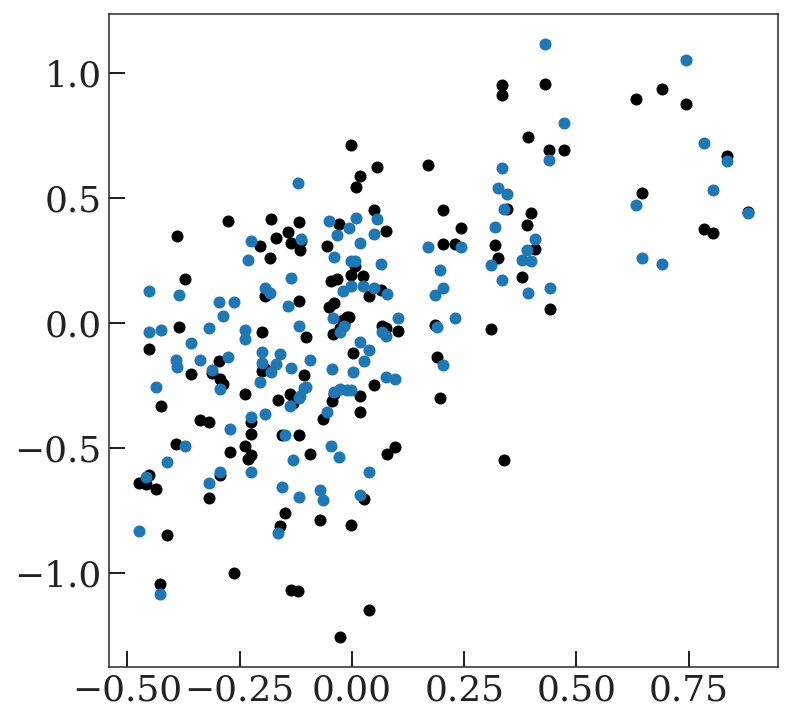

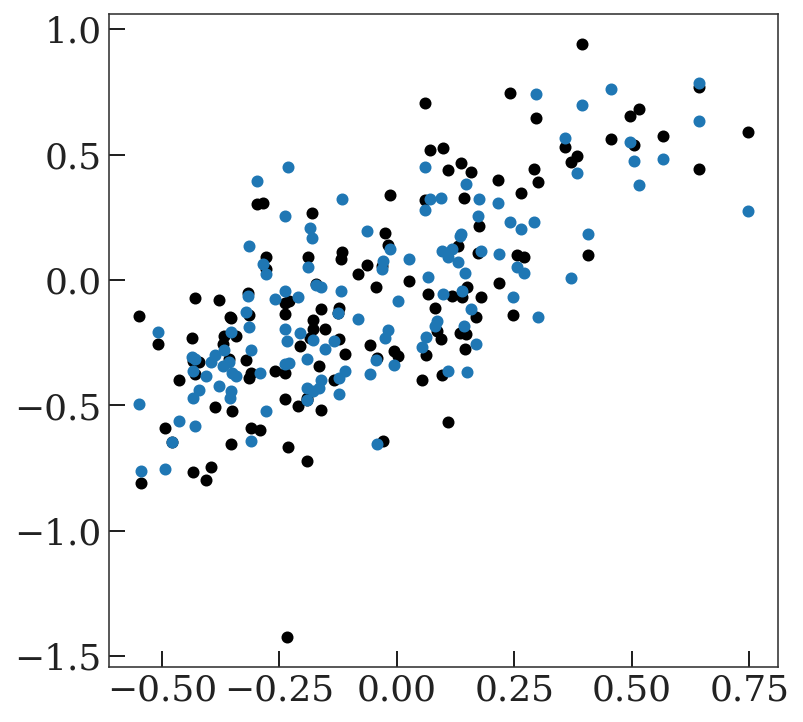

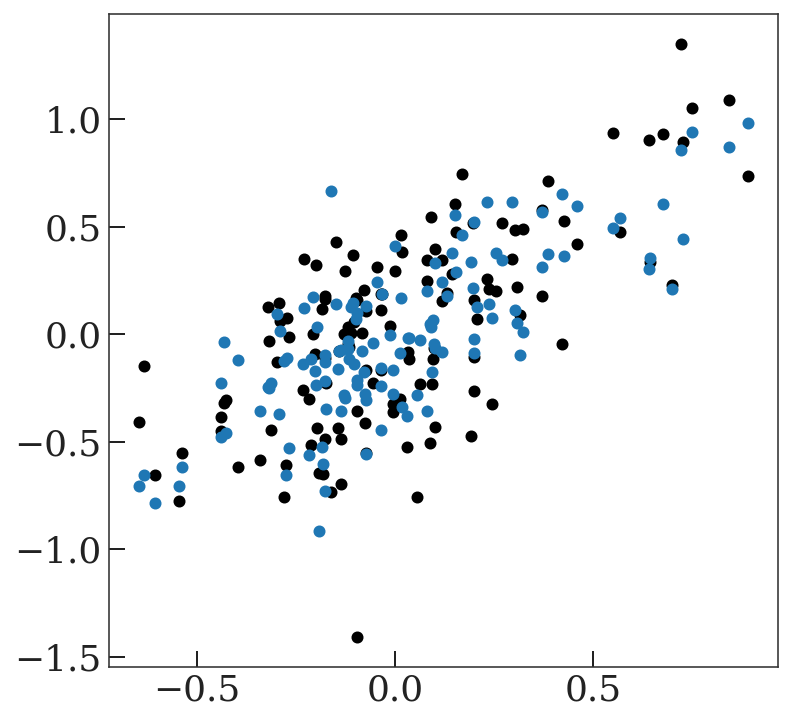

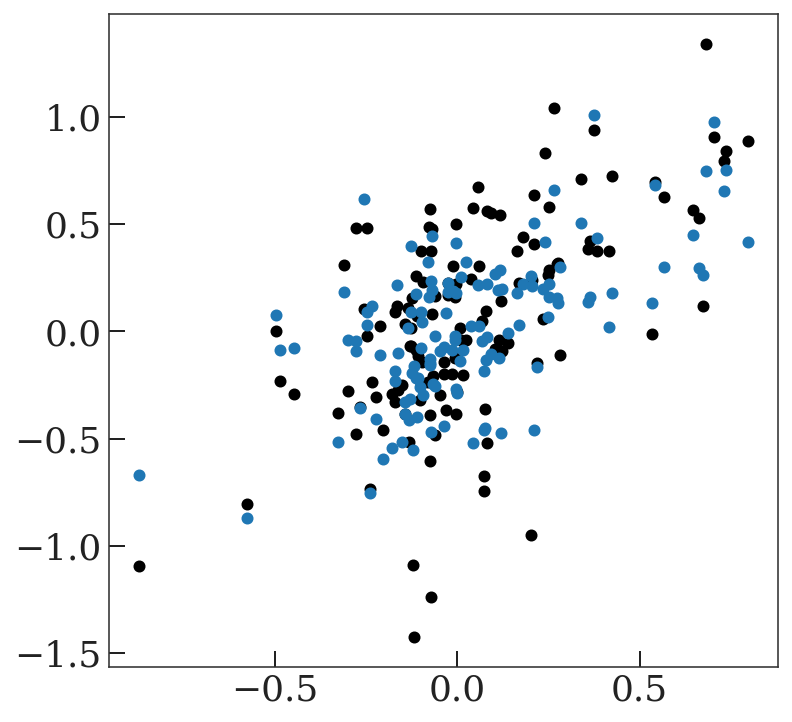

In [30]:
for q in range(y_train.shape[1]):
    plt.figure()
    plt.scatter(
        y_train[idx, q],
        y_train_predict0[:, q]
    )
    plt.scatter(
        y_train[idx, q],
        y_train_predict[:, q]
    )

In [31]:
x0 = llvm.pack_p()
print(x0.shape)
llvm(x0)

(1028,)


DeviceArray(6004.6228573, dtype=float64)

In [32]:
y_valid_predict0 = llvm.predict_y(
    X_valid[valid_n:valid_n+1], 
    X_valid_err[valid_n:valid_n+1], 
    llvm.par_state
)

y_valid_predict = llvm.predict_y(
    X_valid[valid_n:valid_n+1], 
    X_valid_err[valid_n:valid_n+1], 
    res_state
)

print(lbl._untransform(y_valid[valid_n:valid_n+1]))
print(lbl._untransform(y_valid_predict0))
print(lbl._untransform(y_valid_predict))

{'schmag': array([1.70533209]), 'TEFF': array([4676.25907858]), 'M_H': array([-0.23677003]), 'logg': array([2.51536129])}
{'schmag': array([1.76855865]), 'TEFF': array([4694.85459124]), 'M_H': array([-0.22001107]), 'logg': array([2.66631022])}
{'schmag': array([1.7855913]), 'TEFF': array([4707.30113955]), 'M_H': array([-0.22346273]), 'logg': array([2.63342455])}


### Run for a bunch of validation stars:

In [33]:
from tqdm import trange

In [34]:
Nvalid = 128
y_valid_predict = np.zeros((Nvalid, y_valid.shape[1]))
for valid_n in trange(y_valid_predict.shape[0]):
    idx = inds[valid_n]

    rng = np.random.default_rng(42)
    n_labels = y_train.shape[1]
    n_latents = n_labels + 1
    B = np.zeros((n_labels, n_latents))
    B[:n_labels, :n_labels] = np.eye(n_labels)

    llvm = LinearLVM(
        X_train[idx], y_train[idx], 
        X_train_err[idx], y_train_err[idx], 
        B, alpha=1e-1, beta=1e-1, 
        rng=rng
    )
    x0 = llvm.pack_p()
    
    opt = optax.adam(1e-4)
    solver = jaxopt.OptaxSolver(opt=opt, fun=llvm, maxiter=2**14)
    res_adam = solver.run(x0)
    
    res_state = llvm.unpack_p(res_adam.params)
    
    y_valid_predict[valid_n] = llvm.predict_y(
        X_valid[valid_n:valid_n+1], 
        X_valid_err[valid_n:valid_n+1], 
        res_state
    )
    
y_valid_subset = y_valid[:Nvalid]
y_valid_subset_err = y_valid_err[:Nvalid]

100%|██████████| 128/128 [05:01<00:00,  2.35s/it]


Text(0, 0.5, 'schlummernd')

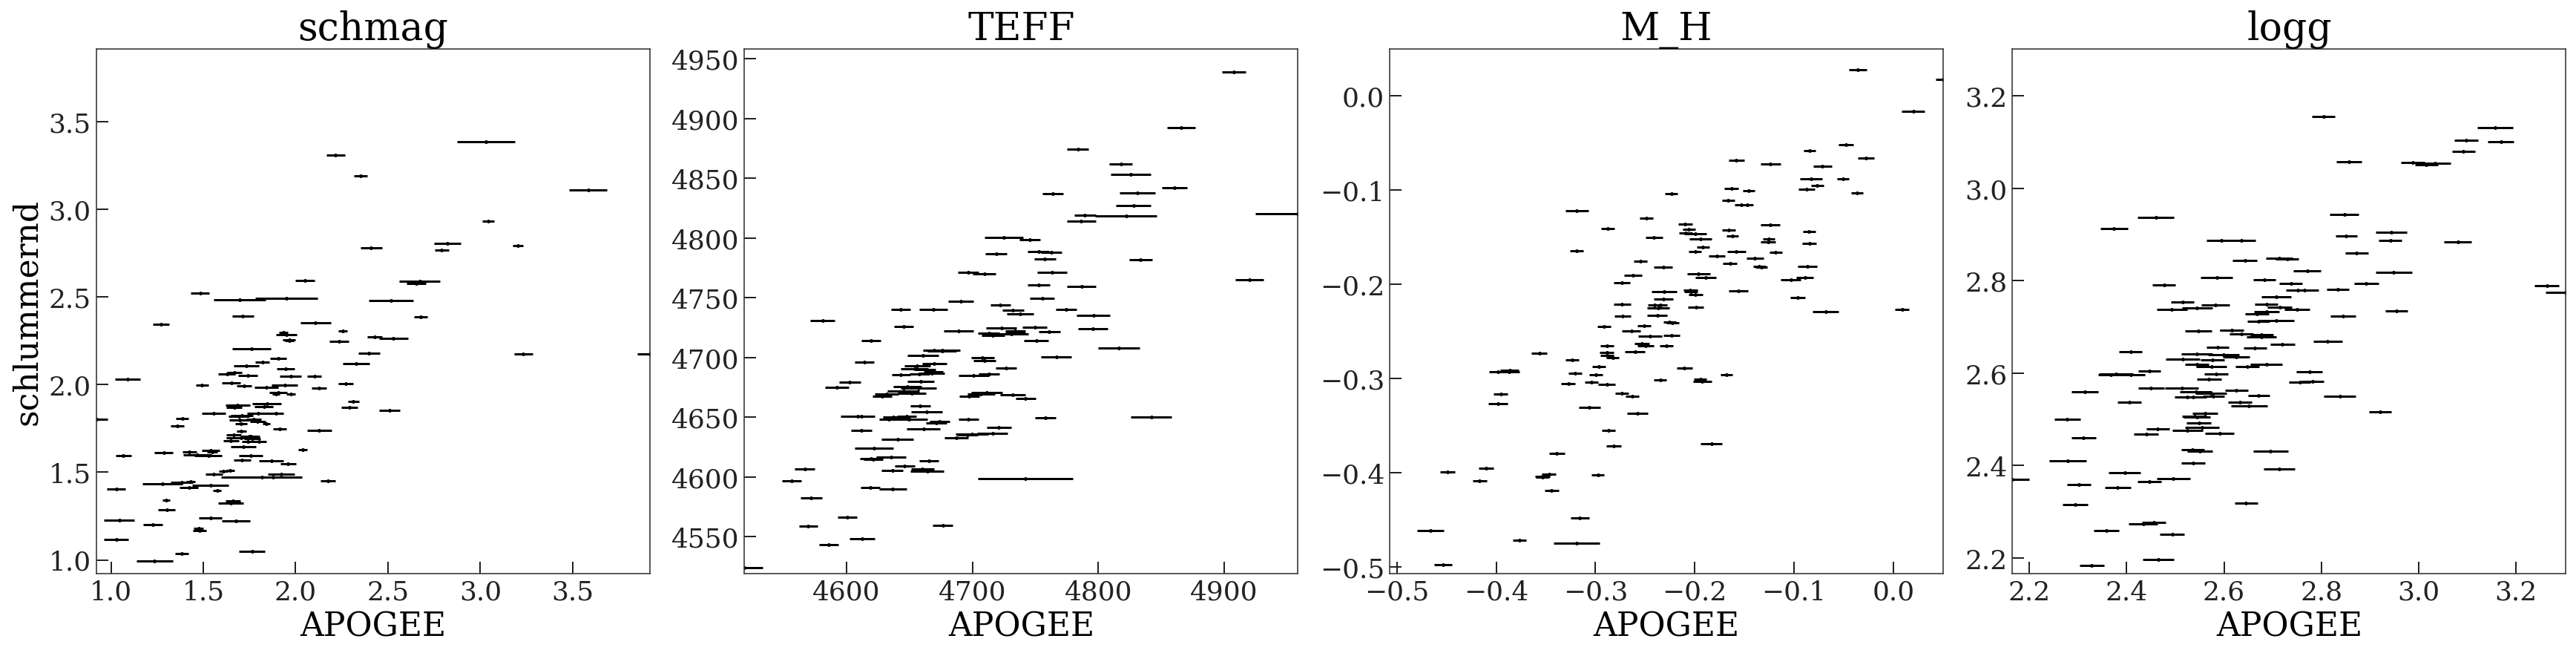

In [35]:
fig, axes = plt.subplots(
    1, y_valid_subset.shape[1], 
    figsize=(y_valid_subset.shape[1] * 6, 6),
    constrained_layout=True
)

_predict = lbl._untransform(y_valid_predict)
_valid = lbl._untransform(y_valid_subset)
_valid_err = lbl._untransform(y_valid_subset_err, err=True)

for q, (ax, name) in enumerate(zip(axes, _predict.keys())):
    ax.errorbar(
        _valid[name],
        _predict[name],
        xerr=_valid_err[name],
        ls='none'
    )
    ax.set_title(name)
    
    lim = (_valid[name].min(), _valid[name].max())
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
for ax in axes:
    ax.set_xlabel('APOGEE')
axes[0].set_ylabel('schlummernd')

In [36]:
for name in _predict.keys():
    dy = _predict[name] - _valid[name]
    mad_std = 1.5 * MAD(dy)
    std_deconv = np.sqrt(np.var(dy) - _valid_err[name]**2)
    mad_std_deconv = np.sqrt(mad_std**2 - _valid_err[name]**2)
    print(
        f"{name}:\n"
        f"  sigma={np.std(dy):.3f}\n"
        f"  median deconv. sigma={np.median(std_deconv):.3f}\n"
        f"  sigma_MAD={mad_std:.3f}\n"
        f"  median deconv. sigma_MAD={np.median(mad_std_deconv):.3f}\n"
    )

schmag:
  sigma=0.417
  median deconv. sigma=0.414
  sigma_MAD=0.338
  median deconv. sigma_MAD=0.335

TEFF:
  sigma=54.252
  median deconv. sigma=53.458
  sigma_MAD=50.032
  median deconv. sigma_MAD=49.170

M_H:
  sigma=0.071
  median deconv. sigma=0.070
  sigma_MAD=0.064
  median deconv. sigma_MAD=0.063

logg:
  sigma=0.180
  median deconv. sigma=0.178
  sigma_MAD=0.147
  median deconv. sigma_MAD=0.144



## Per neighborhood:

TODO: PCA the bp/rp coefficients and cluster?? like we did in apogee-dr17-distances

---

In [ ]:
solver = jaxopt.LBFGS(fun=llvm, maxiter=10000)
res_bfgs = solver.run(x0)
print(res_bfgs.state.iter_num)
llvm(res_bfgs.params)

In [ ]:
opt = optax.adam(1.)
solver = jaxopt.OptaxSolver(opt=opt, fun=llvm, maxiter=100000)
res_adam = solver.run(x0)
print(res_adam.state.iter_num)
llvm(res_adam.params)

In [ ]:
# llvm.unpack_p(res_bfgs.params)

In [ ]:
res_state = llvm.unpack_p(res_bfgs.params)
# res_state = llvm.unpack_p(res_adam.params)

# y_valid_predict0 = llvm.predict_y(X_valid, X_valid_err, llvm.par_state)
# y_valid_predict = llvm.predict_y(X_valid, X_valid_err, res_state)

y_valid_predict = llvm.predict_y(
    X_valid[valid_n:valid_n+1], 
    X_valid_err[valid_n:valid_n+1], 
    res_state
)

In [ ]:
y_valid[valid_n:valid_n+1]

In [ ]:
y_valid_predict0

In [ ]:
y_valid_predict

In [ ]:
y_valid_err[valid_n:valid_n+1]

In [ ]:
# infer for test-set objects
for k in range(y_valid.shape[1]):
    plt.figure()
#     plt.scatter(y_star[:, k], ystar_predict0[:, k], c="r", marker="o")
    plt.scatter(y_valid[:, k], y_valid_predict[:, k], c="k", marker="o")
    plt.plot([y_valid[:, k].min(), y_valid[:, k].max()],
             [y_valid[:, k].min(), y_valid[:, k].max()], 
             marker='', color='tab:blue')
    plt.xlabel(f"true label {k}")
    plt.ylabel(f"prediction of label {k}")
    plt.title("held-out data")